In [24]:
import numpy as np
import torch
from comet_ml import Experiment,ExistingExperiment
from comet_ml.integration.pytorch import log_model
import yaml
import h5py
import matplotlib.pyplot as plt

In [25]:
from Finetune_hep.python import train,helpers,models

In [26]:
device = helpers.get_device()
data_config_Xbb = 'config/ParT_Xbb_config.yaml'
data_config_latent = 'config/ParT_latent_config.yaml'
data_config_latent_hlf = 'config/ParT_latent_hlf_config.yaml'
data_config_Xbb_hlf = 'config/ParT_Xbb_hlf_config.yaml'

In [27]:
model_Xbb = models.full_model(data_config_Xbb,for_inference=True)  
model_latent = models.full_model(data_config_latent,for_inference=False)  
model_Xbb_hlf = models.full_model(data_config_Xbb_hlf,for_inference=True,save_representaions=True)  
model_latent_hlf = models.full_model(data_config_latent_hlf,for_inference=True,save_representaions=True)  

In [28]:
model_latent_hlf

ParticleTransformerWrapper(
  (head): InvariantModel(
    (phi): Sequential(
      (0): Linear(in_features=133, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (rho): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
  (mod): ParticleTransformer(
    (trimmer): SequenceTrimmer()
    (embed): Embed(
      (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (embed): Sequential(
        (0): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=17,

In [29]:
model_Xbb_hlf

ParticleTransformerWrapper(
  (Xbb): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
  (head): InvariantModel(
    (phi): Sequential(
      (0): Linear(in_features=6, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (rho): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
  (mod): ParticleTransformer(
    (trimmer): SequenceTrimmer()
    (embed): Embed(
      (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (embed): Sequential(
        (0): Layer

In [30]:
model_latent

ParticleTransformerWrapper(
  (head): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (mod): ParticleTransformer(
    (trimmer): SequenceTrimmer()
    (embed): Embed(
      (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (embed): Sequential(
        (0): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=17, out_features=128, bias=True)
        (2): GELU(approximate='none')
        (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (4): Linear(in_features=128, out_features=512, bias=True)
        (5): GELU(approximate='none')
        (6): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (7): Linear(in_features=512, 

In [31]:
model_Xbb.Task

'Xbb'

In [32]:
with h5py.File('../data/Data_val_sig_30.h5', 'r') as sample_sig:
    data = {}
    print(sample_sig.keys())
    print(sample_sig['X_jet'])
    print(sample_sig['X_jet_singlejet'])
    print(sample_sig['X_pfo_singlejet'])
    data['X_jet'] = sample_sig['X_jet'][:]
    data['X_pfo'] = sample_sig['X_pfo'][:]
    data['labels'] = sample_sig['labels'][:]
    data['jet_mask'] = sample_sig['jet_mask'][:]
    inputs = helpers.build_features_and_labels(data)
    data_Xbb = {}
    data_Xbb['X_jet'] = sample_sig['X_jet_singlejet'][:]
    data_Xbb['X_pfo'] = sample_sig['X_pfo_singlejet'][:]
    data_Xbb['labels'] = sample_sig['X_label_singlejet'][:]
    inputs_Xbb = helpers.build_features_and_labels_Xbb(data_Xbb)
with h5py.File('../data/Data_val_bkg_100.h5', 'r') as sample_bkg:
    data_bkg = {}
    print(sample_bkg.keys())
    print(sample_bkg['X_jet'])
    print(sample_bkg['X_jet_singlejet'])
    print(sample_bkg['X_pfo_singlejet'])
    data_bkg['X_jet'] = sample_bkg['X_jet'][:100]
    data_bkg['X_pfo'] = sample_bkg['X_pfo'][:100]
    data_bkg['labels'] = sample_bkg['labels'][:100]
    data_bkg['jet_mask'] = sample_bkg['jet_mask'][:100]
    inputs_bkg = helpers.build_features_and_labels(data_bkg)
    data_Xbb_bkg = {}
    data_Xbb_bkg['X_jet'] = sample_bkg['X_jet_singlejet'][:100]
    data_Xbb_bkg['X_pfo'] = sample_bkg['X_pfo_singlejet'][:100]
    data_Xbb_bkg['labels'] = sample_bkg['X_label_singlejet'][:100]
    inputs_Xbb_bkg = helpers.build_features_and_labels_Xbb(data_Xbb_bkg)    


<KeysViewHDF5 ['X_jet', 'X_jet_singlejet', 'X_label', 'X_label_singlejet', 'X_pfo', 'X_pfo_singlejet', 'jet_mask', 'labels']>
<HDF5 dataset "X_jet": shape (26, 5, 6), type "<f8">
<HDF5 dataset "X_jet_singlejet": shape (60, 6), type "<f8">
<HDF5 dataset "X_pfo_singlejet": shape (60, 100, 15), type "<f8">
<KeysViewHDF5 ['X_jet', 'X_jet_singlejet', 'X_label', 'X_label_singlejet', 'X_pfo', 'X_pfo_singlejet', 'jet_mask', 'labels']>
<HDF5 dataset "X_jet": shape (3536, 5, 6), type "<f8">
<HDF5 dataset "X_jet_singlejet": shape (7975, 6), type "<f8">
<HDF5 dataset "X_pfo_singlejet": shape (7975, 100, 15), type "<f8">


In [33]:
inputs.keys()

dict_keys(['pf_points', 'pf_features', 'pf_vectors', 'pf_mask', 'jet_mask', 'label', 'hl_feats'])

In [34]:
pf_points = torch.tensor(inputs['pf_points']).float().to(device)
pf_features = torch.tensor(inputs['pf_features']).float().to(device)
pf_vectors = torch.tensor(inputs['pf_vectors']).float().to(device)
pf_mask = torch.tensor(inputs['pf_mask']).float().to(device)
hl_feats = torch.tensor(inputs['hl_feats']).float().to(device)
jet_mask = torch.tensor(inputs['jet_mask']).float().to(device)

preds = model_latent(pf_points,pf_features,pf_vectors,pf_mask,jet_mask,hl_feats)

In [35]:
preds.shape

torch.Size([26, 1])

In [36]:
pf_points = torch.tensor(inputs_Xbb['pf_points']).float().to(device)
pf_features = torch.tensor(inputs_Xbb['pf_features']).float().to(device)
pf_vectors = torch.tensor(inputs_Xbb['pf_vectors']).float().to(device)
pf_mask = torch.tensor(inputs_Xbb['pf_mask']).float().to(device)

pf_points_bkg = torch.tensor(inputs_Xbb_bkg['pf_points']).float().to(device)
pf_features_bkg = torch.tensor(inputs_Xbb_bkg['pf_features']).float().to(device)
pf_vectors_bkg = torch.tensor(inputs_Xbb_bkg['pf_vectors']).float().to(device)
pf_mask_bkg = torch.tensor(inputs_Xbb_bkg['pf_mask']).float().to(device)

preds_Xbb = model_Xbb(pf_points,pf_features,pf_vectors,pf_mask)

In [37]:
preds_Xbb.shape

torch.Size([60, 1])

In [38]:
idxmap = helpers.get_idxmap('config/train.txt')
idxmap_val = helpers.get_idxmap('config/val.txt')
integer_file_map = helpers.create_integer_file_map(idxmap)
integer_file_map_val = helpers.create_integer_file_map(idxmap_val)

In [39]:
model_Xbb.load_state_dict(torch.load('/Users/matthiasvigl/Xbb_lr0.01_bs512_subset0.1.pt',map_location=torch.device(device)))

<All keys matched successfully>

In [40]:
model_latent = helpers.load_weights(model_latent,'/Users/matthiasvigl/Xbb_lr0.01_bs512_subset0.1.pt',device)
model_latent_hlf = helpers.load_weights(model_latent_hlf,'/Users/matthiasvigl/Xbb_lr0.01_bs512_subset0.1.pt',device)
model_Xbb_hlf = helpers.load_weights(model_Xbb_hlf,'/Users/matthiasvigl/Xbb_lr0.01_bs512_subset0.1.pt',device)
model_Xbb = helpers.load_weights(model_Xbb,'/Users/matthiasvigl/Xbb_lr0.01_bs512_subset0.1.pt',device)

loading weights :
dict_keys(['mod.cls_token', 'mod.embed.input_bn.weight', 'mod.embed.input_bn.bias', 'mod.embed.input_bn.running_mean', 'mod.embed.input_bn.running_var', 'mod.embed.input_bn.num_batches_tracked', 'mod.embed.embed.0.weight', 'mod.embed.embed.0.bias', 'mod.embed.embed.1.weight', 'mod.embed.embed.1.bias', 'mod.embed.embed.3.weight', 'mod.embed.embed.3.bias', 'mod.embed.embed.4.weight', 'mod.embed.embed.4.bias', 'mod.embed.embed.6.weight', 'mod.embed.embed.6.bias', 'mod.embed.embed.7.weight', 'mod.embed.embed.7.bias', 'mod.pair_embed.embed.0.weight', 'mod.pair_embed.embed.0.bias', 'mod.pair_embed.embed.0.running_mean', 'mod.pair_embed.embed.0.running_var', 'mod.pair_embed.embed.0.num_batches_tracked', 'mod.pair_embed.embed.1.weight', 'mod.pair_embed.embed.1.bias', 'mod.pair_embed.embed.2.weight', 'mod.pair_embed.embed.2.bias', 'mod.pair_embed.embed.2.running_mean', 'mod.pair_embed.embed.2.running_var', 'mod.pair_embed.embed.2.num_batches_tracked', 'mod.pair_embed.embed.4.w

In [41]:
with torch.no_grad():
    model_Xbb.eval()
    preds_Xbb = model_Xbb(pf_points,pf_features,pf_vectors,pf_mask)
    preds_Xbb_bkg = model_Xbb(pf_points_bkg,pf_features_bkg,pf_vectors_bkg,pf_mask_bkg)

(array([75.,  7.,  1.,  4.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.

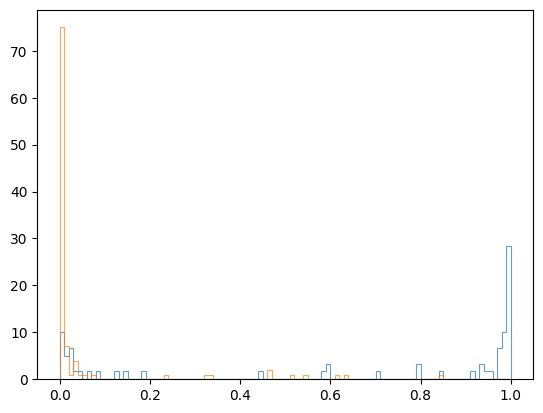

In [42]:
b=np.linspace(0,1,101)
fig, ax = plt.subplots()
ax.hist(preds_Xbb.detach().numpy(), lw=0.8,bins=b,histtype='step', density=True, alpha=0.7)
ax.hist(preds_Xbb_bkg.detach().numpy(), lw=0.8,bins=b,histtype='step', density=True, alpha=0.7)